## Prepare imports

In [1]:
import torch
import matplotlib.pyplot as plt

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE

from models.ectencoder_mnist import BaseModel as BaseECT

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn


from datasets.mnist import MnistDataModule
from datasets.config import MnistDataModuleConfig
from layers.ect import EctLayer, EctConfig
from datasets.modelnet import ModelNetDataModule, ModelNetDataModuleConfig
from models.ectencoder_mnist import BaseModel


DEVICE = "cuda:0"

V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
    ]
)


## Load Models and Data

In [2]:
V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
        torch.zeros_like(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
    ]
)

layer = EctLayer(
    EctConfig(num_thetas=64, bump_steps=64, normalized=True, device=DEVICE), v=V
)

dm = ModelNetDataModule(ModelNetDataModuleConfig(name="10"))


litmodel = BaseModel.load_from_checkpoint(
    "./trained_models/ectencoder_3d.ckpt",
    layer=layer,
    ect_size=64,
    hidden_size=512,
    num_pts=100,
).to(DEVICE)



## Generate an ECT and use VAE as autoencoder to recreate the ECT

In [3]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)

# Decode points
recon_pts = litmodel.model.forward(ect)




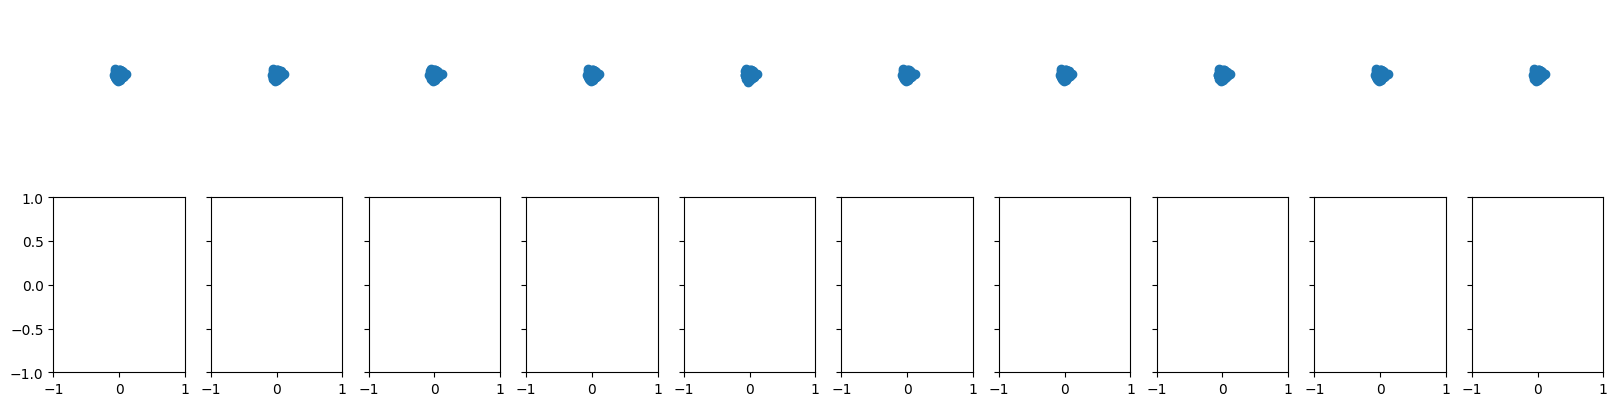

In [5]:
n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
)


for recon_pts,ax in zip(recon_pts,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,3).cpu().detach().squeeze().numpy()
    # recon_pts = rotate(recon_pts, degrees=-90)
    # recon_vae_pts = rotate(recon_vae_pts, degrees=-90)


    ax[0].scatter(recon_pts[:,0],recon_pts[:,1])
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    # ax[1].scatter(recon_vae_pts[:,0],recon_vae_pts[:,1])
    # ax[1].set_xlim([-1,1])
    # ax[1].set_ylim([-1,1])
    # ax[1].set_aspect(1)
    # ax[1].axis("off")

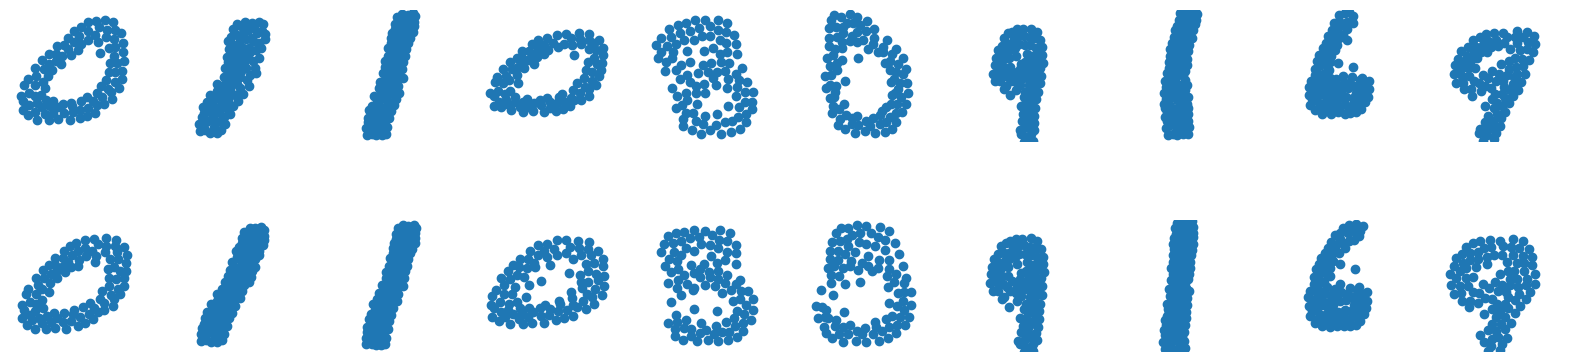

In [34]:
# Pass reconstruction through the point cloud decoder

import numpy as np

def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)



with torch.no_grad():
    recon_vae_batch = ect_encoder_litmodel.model.forward(decoded)
    recon_batch = ect_encoder_litmodel.model.forward(ect)


n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
)


for recon_pts, recon_vae_pts,ax in zip(recon_batch,recon_vae_batch,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)


    ax[0].scatter(recon_pts[:,0],recon_pts[:,1])
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    ax[1].scatter(recon_vae_pts[:,0],recon_vae_pts[:,1])
    ax[1].set_xlim([-1,1])
    ax[1].set_ylim([-1,1])
    ax[1].set_aspect(1)
    ax[1].axis("off")
    

## Sample from VAE and reconstruct points 

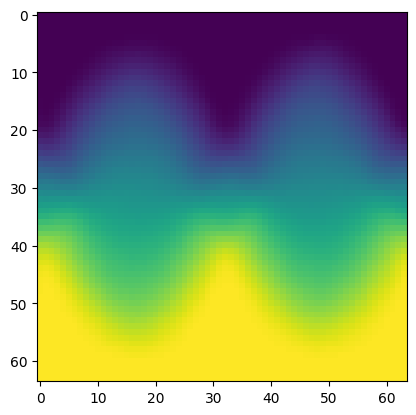

In [65]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1) / 2
recon_samples = ect_encoder_litmodel.model.forward(samples)

plt.imshow(samples[0].squeeze().cpu().detach().numpy())

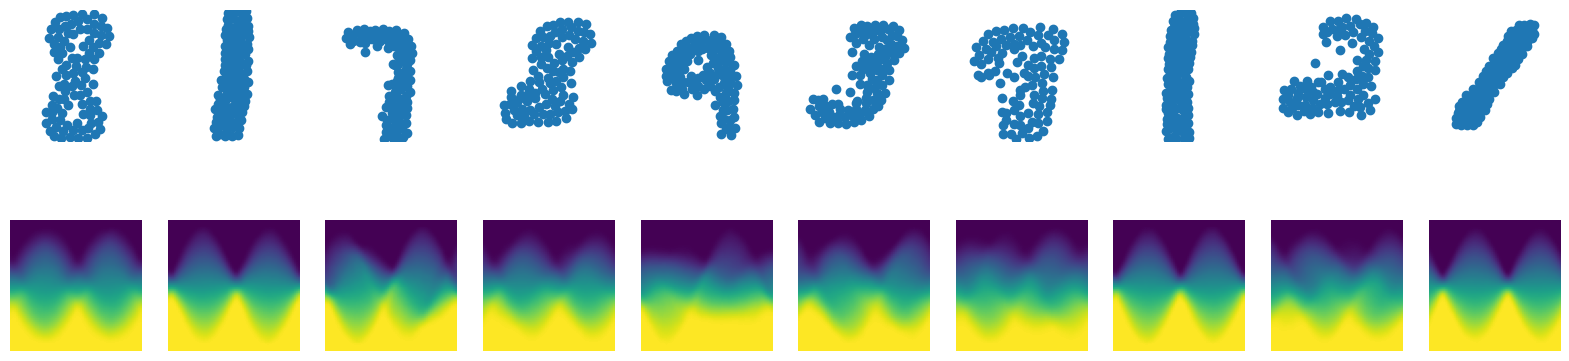

In [66]:
n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, figsize=(20,5)
)


for samples_pts,sample,ax in zip(recon_samples,samples,axes.T):
    samples_pts = samples_pts.view(-1,2).cpu().detach().squeeze().numpy()
    samples_pts = rotate(samples_pts, degrees=-90)
    ax[0].scatter(samples_pts[:,0],samples_pts[:,1])
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    ax[1].imshow(sample.squeeze().cpu().detach().numpy())
    ax[1].axis("off")
    